# Imports & Brain Data

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from IPython.core.display import HTML
display(HTML("<style>.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {padding: 0; border: 0;}</style>"));

In [3]:
from tqdm import tqdm_notebook as tqdm
from copy import deepcopy
from scipy import stats
from glob import glob
from PIL import Image

import numpy as np
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns

import io, os, sys
import torch
import pickle
%matplotlib inline
sys.path.append('..')

In [4]:
brain_data_dir = '../neural_data/'
output_dir = 'zoology_results/'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

In [5]:
brain_rdms = pickle.load(open(brain_data_dir + 'rdms_reliable.pkl', 'rb'))
noise_ceiling = pd.read_csv(brain_data_dir + 'rdms_splithalf.csv')

# ImageNet (Object Recognition) Architectures

In [6]:
from model_opts.model_options import get_model_options
model_options = get_model_options(model_type='imagenet')

all_model_rdms = {}
source_dir = 'model_rdms/'
for model in tqdm(model_options):
    if os.path.exists(os.path.join(source_dir, model + '_rdms.pkl')):
        all_model_rdms[model] = pickle.load(open(os.path.join(source_dir, model + '_rdms.pkl'), 'rb'))

### Representational Similarity Analysis (RSA)

In [7]:
from scipy.stats import pearsonr, spearmanr

output_file = output_dir + 'imagenet_models_rsa.csv'
if os.path.exists(output_file):
    rsa = pd.read_csv(output_file)
    
if not os.path.exists(output_file):
    rsa_dict_list = []
    for model in tqdm(all_model_rdms.keys()):
        model_rdms = all_model_rdms[model]
        for area in tqdm(brain_rdms.keys(), leave = False):
            for layer in tqdm(brain_rdms[area].keys(), leave = False):
                brain_rdm = brain_rdms[area][layer]
                for model_layer_index, model_layer in enumerate(tqdm(model_rdms.keys(), leave = False)):
                    model_rdm = model_rdms[model_layer]
                    model_rdm_triu = model_rdm[np.triu_indices(model_rdm.shape[0], k=1)]
                    brain_rdm_triu = brain_rdm[np.triu_indices(brain_rdm.shape[0], k=1)]
                    mouse_model_corr = pearsonr((brain_rdm_triu).flatten(), (model_rdm_triu).flatten())[0]
                    rsa_dict_list.append({'model': model, 'model_layer': model_layer, 
                                          'model_layer_index': model_layer_index,
                                          'model_layer_relative': model_layer_index / len(model_rdms.keys()),
                                          'area': area, 'layer': layer, 'rsa_r': mouse_model_corr})

    rsa = pd.DataFrame(rsa_dict_list)
    rsa.to_csv(output_file, index = None)

In [8]:
rsa['model_name'] = rsa['model'].apply(lambda x: '_'.join(x.split('_')[:-1]))
rsa['neural_site'] = rsa.apply(lambda x: x['area'] + '-' + x['layer'], 1)
rsa['training'] = rsa['model'].apply(lambda x: x.split('_')[-1])

In [9]:
pg.ttest(*rsa.groupby('training')['rsa_r'].apply(lambda x:list(x)))

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,83.495457,212029.574588,two-sided,0.0,"[0.03, 0.03]",0.348552,inf,1.0


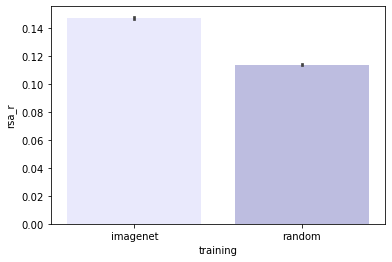

In [10]:
training_results = rsa.groupby(['training'])['rsa_r'].mean().reset_index().sort_values('rsa_r', ascending=False)
p=sns.barplot('training', 'rsa_r', data=rsa, order=['imagenet', 'random'], palette=sns.light_palette('navy'));

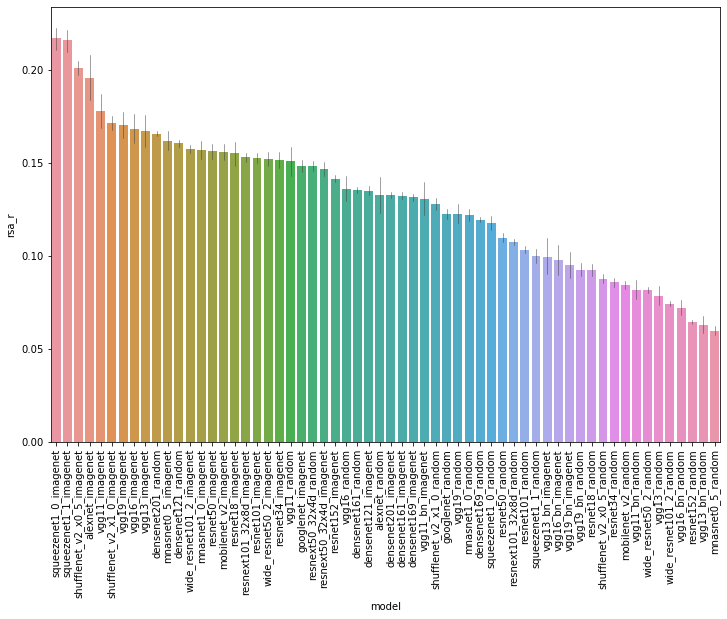

In [12]:
#fig, ax = plt.subplots(figsize=(12,8))
model_results = rsa.groupby(['model'])['rsa_r'].mean().reset_index().sort_values('rsa_r', ascending=False)
p=sns.barplot('model', 'rsa_r', data = rsa, order=model_results['model'], errwidth=0.5);
plt.setp(p.get_xticklabels(), rotation=90);
plt.gcf().set_size_inches(12, 8);

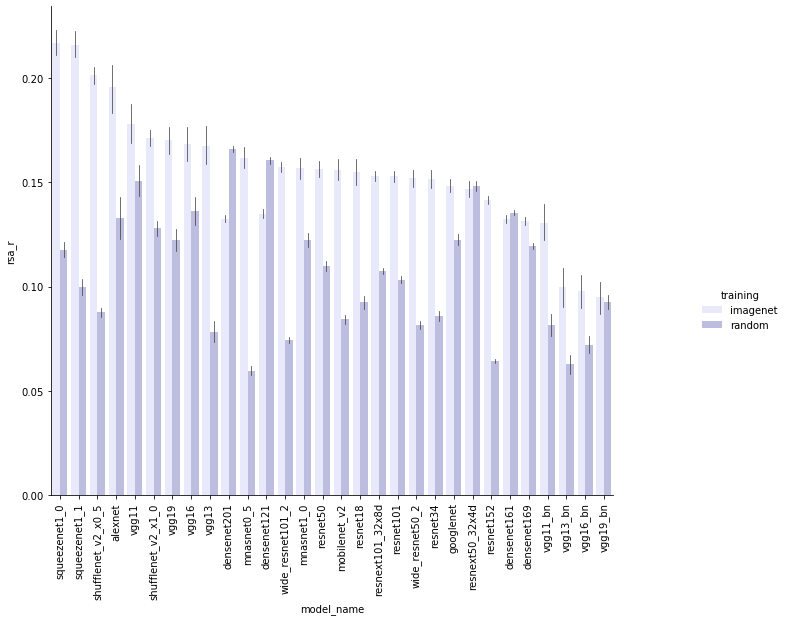

In [13]:
model_results_bytraining = rsa.groupby(['model_name', 'training'])['rsa_r'].mean().reset_index().sort_values(['rsa_r'], ascending=False)
g=sns.catplot(x='model_name', y='rsa_r', hue='training', kind='bar', palette=sns.light_palette('navy'), errwidth=0.75,
              hue_order=['imagenet', 'random'], order=model_results_bytraining['model_name'].unique(), data=rsa)
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat];
[plt.gcf().set_size_inches(12, 8) for ax in g.axes.flat];

In [14]:
rsa_max_scores = rsa[rsa.groupby(['neural_site','model'])['rsa_r'].transform(max) == rsa['rsa_r']]

In [15]:
rsa[rsa.groupby('neural_site')['rsa_r'].transform(max) == rsa['rsa_r']].sort_values(by=['rsa_r'])

,model,model_layer,model_layer_index,model_layer_relative,area,layer,rsa_r,model_name,neural_site,training
80886,densenet121_imagenet,Conv2d-43,133,0.359459,VISrl,layer5,0.138442,densenet121,VISrl-layer5,imagenet
80398,densenet121_imagenet,Conv2d-5,15,0.040541,VISrl,layer4,0.171093,densenet121,VISrl-layer4,imagenet
215669,wide_resnet101_2_imagenet,Conv2d-38,109,0.350482,VISpm,layer6,0.211388,wide_resnet101_2,VISpm-layer6,imagenet
52985,resnet152_imagenet,Conv2d-62,181,0.390086,VISam,layer5,0.268884,resnet152,VISam-layer5,imagenet
160950,shufflenet_v2_x0_5_imagenet,Conv2d-25,71,0.425150,VISal,layer5,0.273634,shufflenet_v2_x0_5,VISal-layer5,imagenet
97841,densenet161_imagenet,ReLU-26,79,0.161224,VISp,layer6,0.274630,densenet161,VISp-layer6,imagenet
213201,wide_resnet101_2_imagenet,ReLU-41,129,0.414791,VISl,layer6,0.275379,wide_resnet101_2,VISl-layer6,imagenet
35562,resnet101_imagenet,Conv2d-38,109,0.350482,VISam,layer4,0.315877,resnet101,VISam-layer4,imagenet
215421,wide_resnet101_2_imagenet,Conv2d-59,172,0.553055,VISpm,layer5,0.340867,wide_resnet101_2,VISpm-layer5,imagenet
38984,resnet101_imagenet,BatchNorm2d-38,110,0.353698,VISpm,layer4,0.359474,resnet101,VISpm-layer4,imagenet


In [16]:
pg.ttest(rsa_max_scores[rsa_max_scores['training'] == 'imagenet']['rsa_r'],
         rsa_max_scores[rsa_max_scores['training'] == 'random']['rsa_r'], paired=True)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,37.061031,629,two-sided,2.592413e-160,"[0.11, 0.12]",1.270973,2.219e+156,1.0


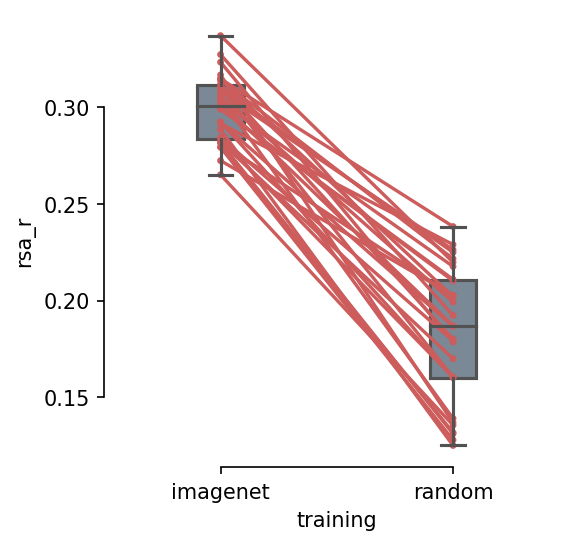

In [60]:
pg.plot_paired(data=rsa_max_scores, dv='rsa_r', within='training', subject='model_name', dpi=150);

In [17]:
rsa_max_scores[rsa_max_scores['training'] == 'imagenet']['rsa_r'].mean()

0.2990778309065295

In [18]:
rsa_max_scores[rsa_max_scores['training'] == 'random']['rsa_r'].mean()

0.1828873523434653

In [72]:
total_site_count = len(rsa['neural_site'].unique())
top_model_status = (rsa[rsa.groupby(['neural_site'])['rsa_r'].transform(max) == rsa['rsa_r']]['model']
                    .value_counts().reset_index().rename(columns={'index':'model','model':'count'}))
top_model_status['model_name'] = top_model_status['model'].apply(lambda x: '_'.join(x.split('_')[:-1]))
top_model_status['training'] = top_model_status['model'].apply(lambda x: x.split('_')[-1])
top_model_status['proportion'] = top_model_status['count'] / total_site_count
top_model_status = top_model_status[['model_name', 'training', 'count', 'proportion']]

In [73]:
top_model_status

,model_name,training,count,proportion
0,shufflenet_v2_x0_5,imagenet,9,0.428571
1,wide_resnet101_2,imagenet,4,0.190476
2,densenet121,imagenet,2,0.095238
3,resnet101,imagenet,2,0.095238
4,densenet201,imagenet,1,0.047619
5,resnet152,imagenet,1,0.047619
6,mnasnet0_5,imagenet,1,0.047619
7,densenet161,imagenet,1,0.047619


In [74]:
top_model_status.to_csv(output_dir + 'top_model_status_rsa.csv')

### Non-Negative Least Squares Linear Regression Analysis (NNLSA)

In [22]:
from nnls_regression import *

In [23]:
output_file = output_dir + 'imagenet_models_nnlsa.csv'
if os.path.exists(output_file):
    nnlsa = pd.read_csv(output_file)
    
if not os.path.exists(output_file):
    nnls_dict_list = []
    for model in tqdm(all_model_rdms.keys()):
        model_rdms = np.stack([all_model_rdms[model][model_layer] for model_layer in all_model_rdms[model].keys()], 2)
        for area in tqdm(brain_rdms.keys(), leave = False):
            for layer in tqdm(brain_rdms[area].keys(), leave = False):
                brain_rdm = brain_rdms[area][layer]
                nnls = kfold_nonnegative_regression(brain_rdm, model_rdms, regression_type='elastic_net', n_splits=6)
                nnls_dict_list.append({'model': model, 'area': area, 'layer': layer, 'nnls_r': nnls[0]})

    nnlsa = pd.DataFrame(nnls_dict_list)
    nnlsa.to_csv(output_file, index=None)

In [24]:
nnlsa['model_name'] = nnlsa['model'].apply(lambda x: '_'.join(x.split('_')[:-1]))
nnlsa['neural_site'] = nnlsa.apply(lambda x: x['area']+'-'+x['layer'], 1)
nnlsa['training'] = nnlsa['model'].apply(lambda x: x.split('_')[-1])

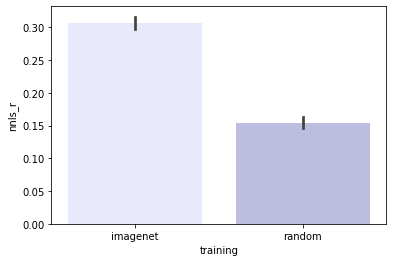

In [25]:
training_results = nnlsa.groupby(['training'])['nnls_r'].mean().reset_index().sort_values('nnls_r', ascending=False)
p=sns.barplot('training', 'nnls_r', data=nnlsa, order=['imagenet', 'random'], palette=sns.light_palette('navy'))

In [26]:
pg.ttest(*nnlsa.groupby('training')['nnls_r'].apply(lambda x:list(x)))

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,24.248184,1258,two-sided,6.964362e-107,"[0.14, 0.17]",1.36623,9.325e+102,1.0


In [27]:
stats.ttest_ind(*nnlsa.groupby('training')['nnls_r'].apply(lambda x:list(x)))

Ttest_indResult(statistic=24.248184237399286, pvalue=6.964361543602056e-107)

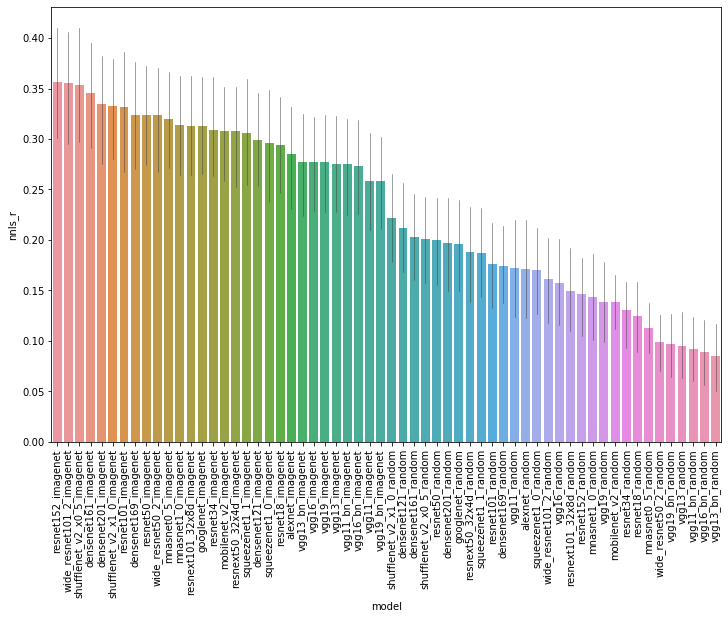

In [28]:
model_results = nnlsa.groupby(['model'])['nnls_r'].mean().reset_index().sort_values('nnls_r', ascending=False)
p=sns.barplot('model', 'nnls_r', data = nnlsa, order=model_results['model'], errwidth=0.5)
plt.setp(p.get_xticklabels(), rotation=90);
plt.gcf().set_size_inches(12, 8);

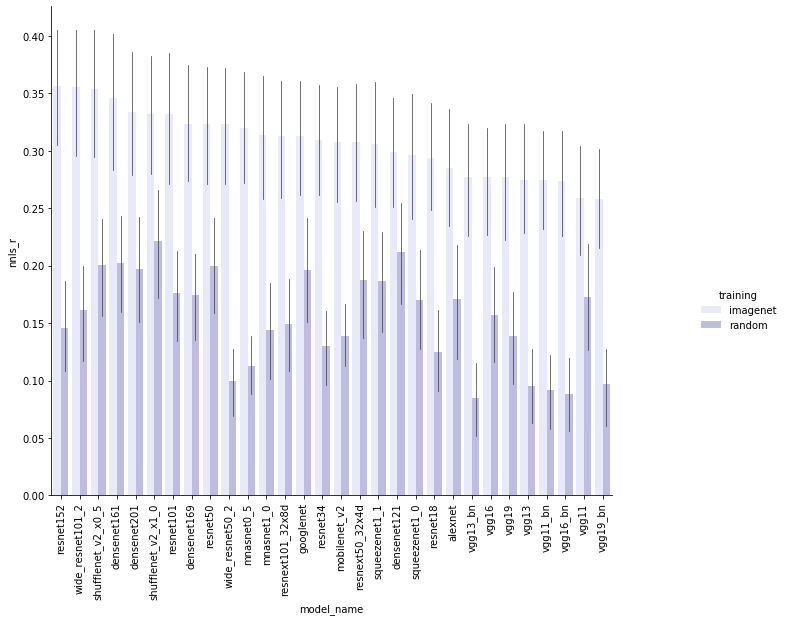

In [29]:
model_results_bytraining = nnlsa.groupby(['model_name', 'training'])['nnls_r'].mean().reset_index().sort_values(['nnls_r'], ascending=False)
g=sns.catplot(x='model_name', y='nnls_r', hue='training', kind='bar', palette=sns.light_palette('navy'), errwidth=0.75,
              hue_order=['imagenet', 'random'], order=model_results_bytraining['model_name'].unique(), data=nnlsa)
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat];
[plt.gcf().set_size_inches(12, 8) for ax in g.axes.flat];

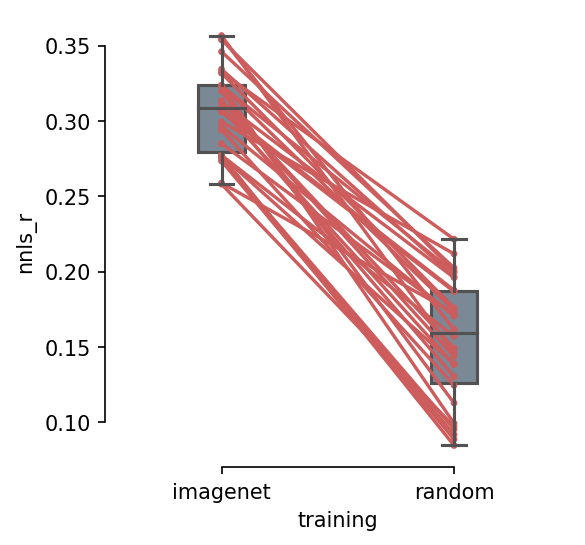

In [34]:
pg.plot_paired(data=nnlsa, dv='nnls_r', within='training', subject='model_name', dpi=150);

In [35]:
training_dictlist = []
for model_name in list(nnlsa['model_name'].unique()):
    training_ttest = stats.ttest_ind(nnlsa[(nnlsa['model_name'] == model_name) & (nnlsa['training'] == 'imagenet')]['nnls_r'], 
                                     nnlsa[(nnlsa['model_name'] == model_name) & (nnlsa['training'] == 'random')]['nnls_r'])
    training_dictlist.append({'model_name': model_name, 'pvalue': training_ttest[1]})
    
training_comparison = pd.DataFrame(training_dictlist)

In [36]:
training_comparison[training_comparison['pvalue'] > .05 / 30]

,model_name,pvalue
0,alexnet,0.003707
1,vgg11,0.018267
15,squeezenet1_1,0.002374
16,densenet121,0.012015
20,googlenet,0.002246
22,shufflenet_v2_x1_0,0.004196
24,resnext50_32x4d,0.001815


In [76]:
training_comparison[training_comparison['pvalue'] < .05 / 30]

,model_name,pvalue
2,vgg13,5.717448e-07
3,vgg16,8.540158e-04
4,vgg19,1.361370e-04
5,vgg11_bn,1.854167e-07
6,vgg13_bn,1.138627e-07
7,vgg16_bn,2.276096e-07
8,vgg19_bn,1.721659e-06
9,resnet18,3.451770e-06
10,resnet34,9.474011e-07
11,resnet50,9.169770e-04


In [38]:
model_results['nnls_r2'] = model_results['nnls_r'] ** 2
model_results['model_name'] = model_results['model'].apply(lambda x: '_'.join(x.split('_')[:-1]))
model_results['training'] = model_results['model'].apply(lambda x: x.split('_')[-1])

In [39]:
nnlsa[nnlsa['nnls_r'] == max(nnlsa['nnls_r'])]

,model,area,layer,nnls_r,model_name,neural_site,training
904,shufflenet_v2_x0_5_imagenet,VISal,layer4,0.551606,shufflenet_v2_x0_5,VISal-layer4,imagenet


In [40]:
model_results.head()

,model,nnls_r,nnls_r2,model_name,training
20,resnet152_imagenet,0.356593,0.127159,resnet152,imagenet
56,wide_resnet101_2_imagenet,0.355239,0.126195,wide_resnet101_2,imagenet
32,shufflenet_v2_x0_5_imagenet,0.353786,0.125165,shufflenet_v2_x0_5,imagenet
4,densenet161_imagenet,0.345901,0.119647,densenet161,imagenet
8,densenet201_imagenet,0.334260,0.111730,densenet201,imagenet


In [41]:
model_results.tail()

,model,nnls_r,nnls_r2,model_name,training
53,vgg19_bn_random,0.097152,0.009439,vgg19_bn,random
47,vgg13_random,0.095366,0.009095,vgg13,random
41,vgg11_bn_random,0.091821,0.008431,vgg11_bn,random
49,vgg16_bn_random,0.088719,0.007871,vgg16_bn,random
45,vgg13_bn_random,0.084606,0.007158,vgg13_bn,random


In [42]:
model_results[model_results['model'].str.contains('imagenet')].tail()

,model,nnls_r,nnls_r2,model_name,training
46,vgg13_imagenet,0.274960,0.075603,vgg13,imagenet
40,vgg11_bn_imagenet,0.274940,0.075592,vgg11_bn,imagenet
48,vgg16_bn_imagenet,0.273361,0.074726,vgg16_bn,imagenet
42,vgg11_imagenet,0.258774,0.066964,vgg11,imagenet
52,vgg19_bn_imagenet,0.257995,0.066561,vgg19_bn,imagenet


In [43]:
model_results[model_results['model'].str.contains('vgg16')]

,model,nnls_r,nnls_r2,model_name,training
50,vgg16_imagenet,0.277172,0.076824,vgg16,imagenet
48,vgg16_bn_imagenet,0.273361,0.074726,vgg16_bn,imagenet
51,vgg16_random,0.157096,0.024679,vgg16,random
49,vgg16_bn_random,0.088719,0.007871,vgg16_bn,random


In [77]:
nnlsa[nnlsa['nnls_r'] == max(nnlsa['nnls_r'])]

,model,area,layer,nnls_r,model_name,neural_site,training
904,shufflenet_v2_x0_5_imagenet,VISal,layer4,0.551606,shufflenet_v2_x0_5,VISal-layer4,imagenet


In [44]:
model_metadata = pd.read_csv('../model_opts/model_metadata.csv')

In [45]:
model_results = model_results.merge(model_metadata, on='model_name')

In [46]:
model_results.head()

,model,nnls_r,nnls_r2,model_name,training,layer_count,parameter_count,total_feature_count
0,resnet152_imagenet,0.356593,0.127159,resnet152,imagenet,464,60192808,66360808
1,resnet152_random,0.146095,0.021344,resnet152,random,464,60192808,66360808
2,wide_resnet101_2_imagenet,0.355239,0.126195,wide_resnet101_2,imagenet,311,126886696,62371816
3,wide_resnet101_2_random,0.161640,0.026127,wide_resnet101_2,random,311,126886696,62371816
4,shufflenet_v2_x0_5_imagenet,0.353786,0.125165,shufflenet_v2_x0_5,imagenet,167,1366792,3284392


In [47]:
stats.pearsonr(model_results[model_results['training'] == 'imagenet']['parameter_count'], 
               model_results[model_results['training'] == 'imagenet']['nnls_r'])

(-0.5745917051834193, 0.0008974526596788712)

In [48]:
stats.pearsonr(model_results[model_results['training'] == 'imagenet']['layer_count'], 
               model_results[model_results['training'] == 'imagenet']['nnls_r'])

(0.7127295129976354, 9.912412831077951e-06)

In [49]:
stats.pearsonr(model_results[model_results['training'] == 'imagenet']['total_feature_count'], 
               model_results[model_results['training'] == 'imagenet']['nnls_r'])

(0.2864111570547502, 0.1249239461481109)

In [50]:
stats.pearsonr(model_results[model_results['training'] == 'random']['parameter_count'], 
               model_results[model_results['training'] == 'random']['nnls_r'])

(-0.5845569346262294, 0.0006933288654606879)

In [51]:
stats.pearsonr(model_results[model_results['training'] == 'random']['layer_count'], 
               model_results[model_results['training'] == 'random']['nnls_r'])

(0.4641393076675712, 0.009775138965924886)

In [52]:
stats.pearsonr(model_results[model_results['training'] == 'random']['total_feature_count'], 
               model_results[model_results['training'] == 'random']['nnls_r'])

(-0.026428261209636962, 0.8897451433736286)

### Non-Negative Least Squares Linear Regression Weight Checking

In [61]:
from nnls_regression import *

In [62]:
def process_nnls_coefs(coefs, model=model):
    coef_mean = np.mean(coefs, axis = 0)
    coef_sd = np.std(coefs, axis=0)
    coef_se = stats.sem(coefs, axis=0)
    coef_ci = coef_se * stats.t.ppf((1 + 0.95) / 2., coefs.shape[0]-1)
    coef_type = ['bias'] if isinstance(coef_mean, np.float64) else ['weight'] * coefs.shape[1]
    return pd.DataFrame({'coef_type': coef_type, 'mean': coef_mean, 'sd': coef_sd, 'se': coef_se, 'ci': coef_ci})

In [64]:
output_file = output_dir + 'nnra_weight_checking.csv'
if os.path.exists(output_file):
    nnlsa_plus = pd.read_csv(output_file)

if not os.path.exists(output_file):
    nnls_dict_list = []
    for model in tqdm(list(all_model_rdms.keys())):
        model_layers = list(all_model_rdms[model].keys())
        model_rdms = np.stack([all_model_rdms[model][model_layer] for model_layer in model_layers], 2)
        for area in tqdm(brain_rdms.keys(), leave = False):
            for layer in tqdm(brain_rdms[area].keys(), leave = False):
                brain_rdm = brain_rdms[area][layer]
                nnls = kfold_nonnegative_regression(brain_rdm, model_rdms, regression_type = 'elastic_net', n_splits=6)
                nnls_weights, nnls_bias = process_nnls_coefs(nnls[1]), process_nnls_coefs(nnls[2])
                for index, weight in nnls_weights.iterrows():
                    nnls_dict_list.append({'area': area, 'layer': layer, 'model': model, 'model_layer': model_layers[index],
                                           'model_layer_index': index, 'nnls_r': nnls[0], 'nnls_weight': weight['mean'],
                                           'nnls_weight_ci': weight['ci'],'nnls_bias': nnls_bias['mean'][0],
                                           'nnls_bias_ci': nnls_bias['ci'][0]})
                    
    nnlsa_plus = pd.DataFrame(nnls_dict_list)
    nnlsa_plus.to_csv(output_file, index = None)

In [ ]:
nnlsa_mean, nnlsa_std = np.mean(nnlsa_plus['nnls_weight']), np.std(nnlsa_plus['nnls_weight'])
nnlsa_plus['nnls_weight_pruned'] = np.where(nnlsa_plus['nnls_weight'] > 3,np.NaN, nnlsa_plus['nnls_weight'])
nnlsa_plus['nnls_weight_log'] = nnlsa_plus['nnls_weight'].apply(lambda x: x if x < 1 else np.log(x))

In [ ]:
p = sns.relplot(x="model_layer_index", y="nnls_weight", col="area", row='layer', kind="line", hue="model",
                sort=True, ci=False, height=5, aspect=.75, facet_kws=dict(sharex=True), data=nnlsa_plus);
p.set_titles(row_template = '{row_name}', col_template = '{col_name}');

In [ ]:
from model_options import get_model_options
model_options = get_model_options(['inception', 'detection', 'segmentation', 'video'])

all_model_rdms = {}
source_dir = 'model_rdms/'
for model in tqdm(model_options):
    if os.path.exists(os.path.join(source_dir, model + '_rdms.pkl')):
        all_model_rdms[model] = pickle.load(open(os.path.join(source_dir, model + '_rdms.pkl'), 'rb'))

### Representational Similarity Analysis (RSA)

In [ ]:
from toolbox.rsafunctions import *

In [ ]:
from scipy.stats import pearsonr, spearmanr

output_file = output_dir + 'other_models_rsa.csv'
if os.path.exists(output_file):
    rsa = pd.read_csv(output_file)
    
if not os.path.exists(output_file):
    rsa_dict_list = []
    for model in tqdm(all_model_rdms.keys()):
        model_rdms = all_model_rdms[model]
        for area in tqdm(brain_rdms.keys(), leave = False):
            for layer in tqdm(brain_rdms[area].keys(), leave = False):
                brain_rdm = brain_rdms[area][layer]
                for model_layer_index, model_layer in enumerate((model_rdms.keys())):
                    model_rdm = model_rdms[model_layer]
                    model_rdm_triu = model_rdm[np.triu_indices(model_rdm.shape[0], k=1)]
                    brain_rdm_triu = brain_rdm[np.triu_indices(brain_rdm.shape[0], k=1)]
                    mouse_model_corr = pearsonr((brain_rdm_triu).flatten(), (model_rdm_triu).flatten())[0]
                    rsa_dict_list.append({'model': model, 'model_layer': model_layer, 
                                          'model_layer_index': model_layer_index,
                                          'model_layer_relative': model_layer_index / len(model_rdms.keys()),
                                          'area': area, 'layer': layer, 'rsa_r': mouse_model_corr})

    rsa = pd.DataFrame(rsa_dict_list)
    rsa.to_csv(output_file, index = None)

In [ ]:
rsa['neural_site'] = rsa.apply(lambda x: x['area'] + '-' + x['layer'], 1)
rsa['model_name'] = rsa['model'].apply(lambda x: x.split('_')[0])
rsa['training'] = rsa['model'].apply(lambda x: x.split('_')[-1])

In [ ]:
training_results = rsa.groupby(['training'])['rsa_r'].mean().reset_index().sort_values('rsa_r', ascending=False)
p=sns.barplot('training', 'rsa_r', data=rsa, order=['pretrained', 'random'], palette=sns.light_palette('navy'))

In [ ]:
pg.ttest(*rsa.groupby('training')['rsa_r'].apply(lambda x:list(x)))

In [ ]:
model_results_bytraining = rsa.groupby(['model_name', 'training'])['rsa_r'].mean().reset_index().sort_values(['rsa_r'], ascending=False)
g=sns.catplot(x='model_name', y='rsa_r', hue='training', kind='bar', palette=sns.light_palette('navy'), errwidth=0.75,
              hue_order=['pretrained', 'random'], order=model_results_bytraining['model_name'].unique(), data=rsa)
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat];

### Non-Negative Least Squares Linear Regression Analysis (NNLSA)

In [ ]:
from toolbox.nnlsfunctions import *

In [ ]:
output_file = output_dir + 'other_models_nnlsa.csv'
if os.path.exists(output_file):
    nnlsa = pd.read_csv(output_file)
    
if not os.path.exists(output_file):
    nnls_dict_list = []
    for model in tqdm(all_model_rdms.keys()):
        model_rdms = np.stack([all_model_rdms[model][model_layer] for model_layer in all_model_rdms[model].keys()], 2)
        for area in tqdm(brain_rdms.keys(), leave = False):
            for layer in tqdm(brain_rdms[area].keys(), leave = False):
                brain_rdm = brain_rdms[area][layer]
                nnls = kfold_cross_validate_nnls(brain_rdm, model_rdms, n_splits=6, n_repeats=10, zero_coef_alert=False)
                nnls_dict_list.append({'model': model, 'area': area, 'layer': layer, 'nnls_r': nnls[0]})

    nnlsa = pd.DataFrame(nnls_dict_list)
    nnlsa.to_csv(output_file, index=None)

In [ ]:
nnlsa['model_name'] = nnlsa['model'].apply(lambda x: '_'.join(x.split('_')[:-1]))
nnlsa['neural_site'] = nnlsa.apply(lambda x: x['area']+'-'+x['layer'], 1)
nnlsa['training'] = nnlsa['model'].apply(lambda x: x.split('_')[-1])

In [ ]:
training_results = nnlsa.groupby(['training'])['nnls_r'].mean().reset_index().sort_values('nnls_r', ascending=False)
p=sns.barplot('training', 'nnls_r', data=nnlsa, order=['pretrained', 'random'], palette=sns.light_palette('navy'))

In [ ]:
pg.ttest(*nnlsa.groupby('training')['nnls_r'].apply(lambda x:list(x)))

In [ ]:
model_results_bytraining = nnlsa.groupby(['model_name', 'training'])['nnls_r'].mean().reset_index().sort_values(['nnls_r'], ascending=False)
g=sns.catplot(x='model_name', y='nnls_r', hue='training', kind='bar', palette=sns.light_palette('navy'), errwidth=0.75,
              hue_order=['pretrained', 'random'], order=model_results_bytraining['model_name'].unique(), data=nnlsa)
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat];